In [106]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

import pandas as pd
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

In [323]:
csv_path = os.path.join("data", "dataset.csv")
df = pd.read_csv(csv_path)

# Remove the 'Name' column from the dataset
dfname = df[['Name', 'Size']]
df = df[df.columns[1:18]]

# Change categorical size to numerical values using One-hot encoding
obj_df = df.select_dtypes(include=['object']).copy()
ord_enc = OrdinalEncoder()
obj_df["SizeNumerical"] = ord_enc.fit_transform(obj_df[["Size"]])
obj_df[["Size", "SizeNumerical"]].head(11)

# Remove the Size column now
del obj_df['Size']
del df['Size']

# Insert the new column size into data frame
df.insert(loc=1, column='Size', value=obj_df)
df

,Threads,Size,branch-instructions,branch-misses in %,L3-cache-misses,L3-cache-miss-rate in %,L3-cache-references,cpu-cycles,total-instructions,IPC,cpu-clock,page-faults,L1-data-cache-loads,L1-instruction-cache-load-misses,LLC-load-misses,Exe-time,Speedup
0,1,2.0,477321653,3.50,8535063,7.916,107817541,5.090221e+09,2903576945,0.57,2209.81,136398,1349583157,41950659,8188583,0.795,1.000000
1,2,2.0,595362996,3.07,8560020,7.744,110535200,6.151556e+09,3390305006,0.55,2677.92,136319,1578688415,49386178,8915359,2.121,0.374823
2,4,2.0,4162666327,0.58,10471647,7.032,148921875,2.647015e+10,19462304148,0.74,11481.64,137099,8875552150,65896687,10338615,5.417,0.146760
3,8,2.0,10867344572,0.36,13102406,5.824,224974098,6.619632e+10,49393791886,0.75,28866.65,136986,22415052319,103758749,12178243,12.121,0.065589
4,1,1.0,654730993,2.74,21490776,12.549,171250825,9.306939e+09,6162394418,0.66,4019.94,137426,2923685478,42699718,20639802,2.844,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,8,1.0,380024113,4.33,8628133,10.169,84843714,4.336135e+09,1803049486,0.42,1883.97,135942,936248965,42641623,8664513,0.012,0.416667
128,1,0.0,436963407,3.65,7767116,9.122,85147232,4.485544e+09,1887918893,0.42,1958.88,136373,992622035,39927278,7146838,0.006,1.000000
129,2,0.0,369908058,4.31,9958151,11.675,85294605,4.193945e+09,1783112628,0.43,1832.71,135780,912393674,43875938,8907745,0.018,0.333333
130,4,0.0,367033696,4.39,9195574,10.466,87861793,4.155612e+09,1746357568,0.42,1806.55,136006,901804291,44578756,8790318,0.015,0.400000


In [324]:
Xdf = df[['total-instructions', 'L3-cache-misses', 'L1-data-cache-loads', 'branch-misses in %', 'L3-cache-references', 'Threads', 'IPC', 'branch-misses in %']]
ydf = df[['Speedup']]
Xlegend = dfname.to_numpy()[::4]

# normalize
X = torch.from_numpy(Xdf.to_numpy())
y = torch.from_numpy(ydf.to_numpy())

In [325]:
X_enc = []
y_enc = []

for i in range(0, X.shape[0], 4):
    x_spl = X[i]
    y_spl = y[i: i + 4].view(4)
    
    X_enc.append(x_spl.numpy())
    y_enc.append(y_spl.numpy())
    
X = torch.from_numpy(np.array(X_enc))
y = torch.from_numpy(np.array(y_enc))

print(X.shape)
print(y.shape)

torch.Size([33, 8])
torch.Size([33, 4])


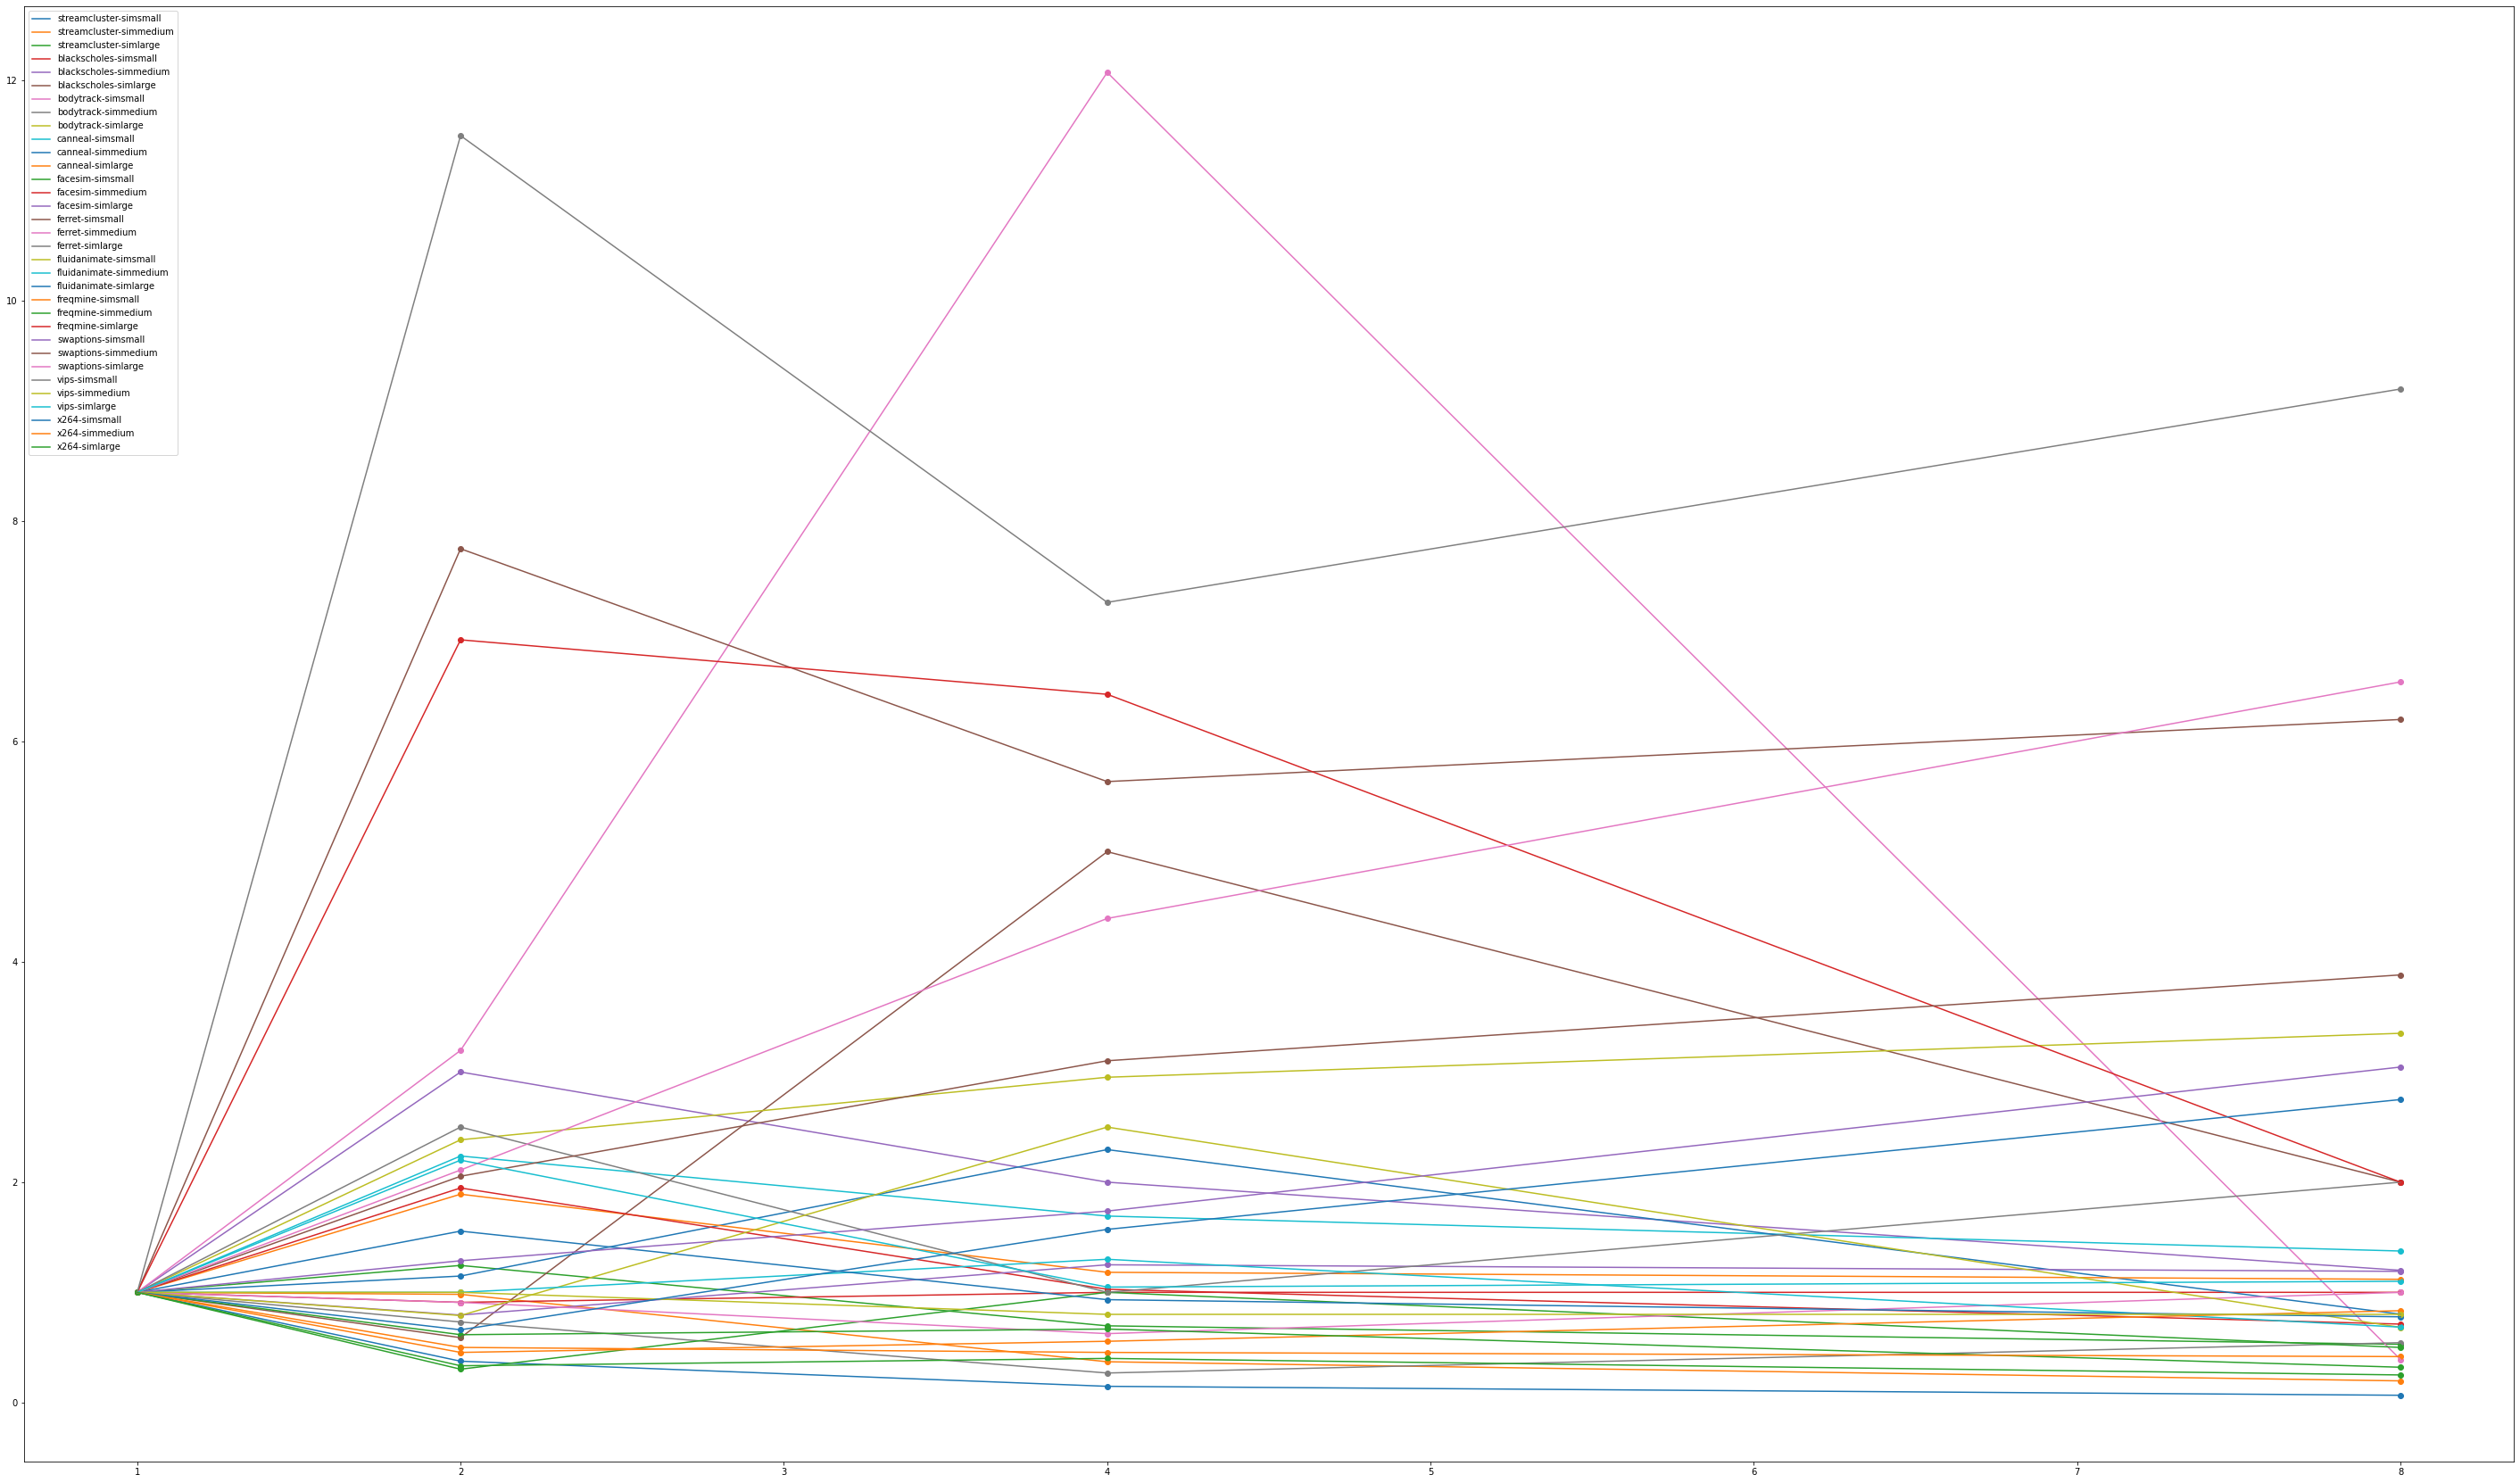

In [331]:
ts = [1, 2, 4, 8]
for idx in range(Xlegend.shape[0]):
    plt.plot(ts, y[idx], label=Xlegend[idx, 0] + '-' + Xlegend[idx, 1])
    plt.scatter(ts, y[idx])
plt.rcParams['figure.figsize'] = [60, 30]
plt.legend()

In [ ]:
# normalize
X = torch.from_numpy(Xdf.to_numpy())
X_mean, X_std = torch.mean(X, dim=0), torch.std(X, dim=0)
X = (X - X_mean) / X_std
X = X.float()

y = torch.from_numpy(ydf.to_numpy())
y_mean, y_std = torch.mean(y, dim=0), torch.std(y, dim=0)
y = (y - y_mean) / y_std
y = y.float()

## Deep learning estimation

Refer to https://github.com/Aman-Chopra/Performance-Prediction-Multithreaded-Applications/blob/master/Code/perf_prediction.ipynb

In [23]:
csv_path = os.path.join("data", "dataset.csv")
df = pd.read_csv(csv_path)

# Remove the 'Name' column from the dataset
df = df[df.columns[1:17]]

# Change categorical size to numerical values using One-hot encoding
obj_df = df.select_dtypes(include=['object']).copy()
ord_enc = OrdinalEncoder()
obj_df["SizeNumerical"] = ord_enc.fit_transform(obj_df[["Size"]])
obj_df[["Size", "SizeNumerical"]].head(11)

# Remove the Size column now
del obj_df['Size']
del df['Size']

# Insert the new column size into data frame
df.insert(loc=1, column='Size', value=obj_df)
df

,Threads,Size,branch-instructions,branch-misses in %,L3-cache-misses,L3-cache-miss-rate in %,L3-cache-references,cpu-cycles,total-instructions,IPC,cpu-clock,page-faults,L1-data-cache-loads,L1-instruction-cache-load-misses,LLC-load-misses,Exe-time
0,1,2.0,477321653,3.50,8535063,7.916,107817541,5.090221e+09,2903576945,0.57,2209.81,136398,1349583157,41950659,8188583,0.795
1,2,2.0,595362996,3.07,8560020,7.744,110535200,6.151556e+09,3390305006,0.55,2677.92,136319,1578688415,49386178,8915359,2.121
2,4,2.0,4162666327,0.58,10471647,7.032,148921875,2.647015e+10,19462304148,0.74,11481.64,137099,8875552150,65896687,10338615,5.417
3,8,2.0,10867344572,0.36,13102406,5.824,224974098,6.619632e+10,49393791886,0.75,28866.65,136986,22415052319,103758749,12178243,12.121
4,1,1.0,654730993,2.74,21490776,12.549,171250825,9.306939e+09,6162394418,0.66,4019.94,137426,2923685478,42699718,20639802,2.844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,8,1.0,380024113,4.33,8628133,10.169,84843714,4.336135e+09,1803049486,0.42,1883.97,135942,936248965,42641623,8664513,0.012
128,1,0.0,436963407,3.65,7767116,9.122,85147232,4.485544e+09,1887918893,0.42,1958.88,136373,992622035,39927278,7146838,0.006
129,2,0.0,369908058,4.31,9958151,11.675,85294605,4.193945e+09,1783112628,0.43,1832.71,135780,912393674,43875938,8907745,0.018
130,4,0.0,367033696,4.39,9195574,10.466,87861793,4.155612e+09,1746357568,0.42,1806.55,136006,901804291,44578756,8790318,0.015


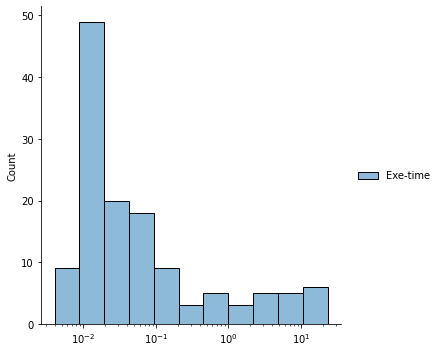

In [245]:
Xdf = df[['total-instructions', 'L3-cache-misses', 'L1-data-cache-loads', 'branch-misses in %', 'L3-cache-references', 'Threads', 'IPC', 'branch-misses in %']]
ydf = df[['Exe-time']]

sns.displot(ydf, log_scale=True);

In [246]:
# normalize
X = torch.from_numpy(Xdf.to_numpy())
X_mean, X_std = torch.mean(X, dim=0), torch.std(X, dim=0)
X = (X - X_mean) / X_std
X = X.float()

y = torch.from_numpy(ydf.to_numpy())
y_mean, y_std = torch.mean(y, dim=0), torch.std(y, dim=0)
y = (y - y_mean) / y_std
y = y.float()

In [247]:
# shuffle
idx = torch.randperm(X.size()[0])
X = X[idx]
y = y[idx]

# split train/test
r = 0.8
Xidx = int(r * X.size()[0])
yidx = int(r * y.size()[0])
X_train, X_test = X[:Xidx], X[Xidx:]
y_train, y_test = y[:yidx], y[yidx:]

y_test_real = (y_test + y_mean) * y_std

print(X_train.size(), X_test.size())
print(y_train.size(), y_test.size())

torch.Size([105, 8]) torch.Size([27, 8])
torch.Size([105, 1]) torch.Size([27, 1])


In [248]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8, 15)
        self.fc2 = nn.Linear(15, 8)
        self.fc3 = nn.Linear(8, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [256]:
torch.manual_seed(2555)
net = Net()
criterion = nn.L1Loss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

for epoch in range(150):  # loop over the dataset multiple times

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    if epoch % 15 == 0:
        y_out_real = (net(X_test) + y_mean) * y_std

        loss_test = criterion(y_out_real, y_test_real)
        print('[%d] loss_train: %.3f loss_test: %.3f' %
              (epoch + 1, loss, loss_test))

print('Finished Training')

[1] loss_train: 0.348 loss_test: 1.324
[16] loss_train: 0.323 loss_test: 1.214
[31] loss_train: 0.298 loss_test: 1.125
[46] loss_train: 0.250 loss_test: 0.958
[61] loss_train: 0.160 loss_test: 0.443
[76] loss_train: 0.137 loss_test: 0.222
[91] loss_train: 0.119 loss_test: 0.137
[106] loss_train: 0.107 loss_test: 0.132
[121] loss_train: 0.101 loss_test: 0.165
[136] loss_train: 0.097 loss_test: 0.172
Finished Training
